In [9]:
import polars as pl
import matplotlib.pyplot as plt

from common.constants.column_types import CPZP_SCHEMA, OZP_SCHEMA
from common.constants.column_names import SHARED_COLUMNS, OZP_COLUMNS

pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(6)

FILE_PATH = "./DATACON_data/OZP_preskladane.csv"


def read_preskladane_data(file_path: str, schema: pl.Schema) -> pl.DataFrame:
    return pl.read_csv(
        file_path,
        null_values=["NA", ""],
        schema=schema,
    )


ozp_df = read_preskladane_data(FILE_PATH, OZP_SCHEMA)

print("OZP DATA: ", ozp_df.schema)

OZP DATA:  Schema({'Id_pojistence': String, 'Pohlavi': Enum(categories=['M', 'F']), 'Rok_narozeni': Int64, 'Posledni_zahajeni_pojisteni': Date, 'Posledni_ukonceni_pojisteni': Date, 'Datum_umrti': Date, 'Typ_udalosti': Enum(categories=['předpis', 'vakcinace']), 'Detail_udalosti': Int64, 'Nazev': String, 'Pocet_baleni': Float64, 'Datum_udalosti': Date, 'léková_forma_zkr': String, 'ATC_skupina': String, 'síla': String, 'doplněk_názvu': String, 'léková_forma': String, 'léčivé_látky': String, 'Equiv_sloucenina': Enum(categories=['TRIAMCINOLON', 'FLUDROKORTISON', 'METHYLPREDNISOLON', 'DEXAMETHASON', 'PREDNISON', 'BETAMETHASON', 'HYDROKORTISON']), 'Prednison_equiv': Float64, 'Pocet_v_baleni': Float64, 'pocet_vakcinaci': Int64, 'ockovany': Enum(categories=['1', '0']), 'pocet_predpisu': Int64})


In [18]:
def get_vekova_kohorta(vek):
    if vek >= 80:
        return "80+"
    elif vek >= 70:
        return "70-79"
    elif vek >= 65:
        return "65-69"
    elif vek >= 60:
        return "60-64"
    elif vek >= 50:
        return "50-59"
    elif vek >= 30:
        return "30-49"
    elif vek >= 12:
        return "12-29"
    else:
        return "<12"

In [49]:
ozp_death_df = ozp_df.filter(pl.col(SHARED_COLUMNS.DATUM_UMRTI).is_not_null())

print(ozp_death_df)

last_vax_and_death_delay = (
    ozp_df.filter(
        (pl.col(SHARED_COLUMNS.DATUM_UMRTI).is_not_null())
        & (pl.col(SHARED_COLUMNS.TYP_UDALOSTI) == "vakcinace")
    )
    .group_by("Id_pojistence")
    .agg(
        [
            pl.col(SHARED_COLUMNS.DATUM_UDALOSTI).max().alias("last_vax_date"),
            pl.col(SHARED_COLUMNS.DATUM_UMRTI)
            .max()
            .alias("Datum_umrti"),  # datum úmrtí by mělo být stejný v rámci ID
            pl.col(SHARED_COLUMNS.ROK_NAROZENI)
            .max()
            .alias("Rok_narozeni"),  # datum úmrtí by mělo být stejný v rámci ID
            pl.col("pocet_vakcinaci")
            .max()
            .alias("Cislo_davky"),  # volitelné – pro rozdělení podle dávky
        ]
    )
    .with_columns(
        [
            (pl.col("Datum_umrti") - pl.col("last_vax_date"))
            .dt.total_days()
            .alias("days_from_vax_to_death")
        ]
    )
    .with_columns(
        (pl.col("Datum_umrti").dt.year() - pl.col("Rok_narozeni")).alias(
            "Vek_v_dobe_umrti"
        )
    )
    .with_columns(
        pl.col("Vek_v_dobe_umrti")
        .map_elements(get_vekova_kohorta, return_dtype=pl.Utf8)
        .alias("Vekova_kohorta")
    )
    .select(
        [
            "Id_pojistence",
            "Vekova_kohorta",  # věková skupina úmrtí
            "days_from_vax_to_death",  # počet dní od poslední vakcinační doby do úmrtí
            "Cislo_davky",  # počet dávek vakcinační
        ]
    )
)

print(last_vax_and_death_delay)


death_groups = (
    last_vax_and_death_delay.with_columns(
        [
            pl.when(pl.col("days_from_vax_to_death") <= 28)
            .then(pl.lit("<= 28 dní"))
            .otherwise(pl.lit("> 28 dní"))
            .alias("vax_to_death_window")
        ]
    )
    .group_by(["Cislo_davky", "Vekova_kohorta", "vax_to_death_window"])
    .len()
    .rename({"len": "death_count"})
    .sort(["Vekova_kohorta", "Cislo_davky", "vax_to_death_window"])
)

print(death_groups)

shape: (221_478, 23)
┌───────────────┬─────────┬──────────────┬───┬─────────────────┬──────────┬────────────────┐
│ Id_pojistence ┆ Pohlavi ┆ Rok_narozeni ┆ … ┆ pocet_vakcinaci ┆ ockovany ┆ pocet_predpisu │
│ ---           ┆ ---     ┆ ---          ┆   ┆ ---             ┆ ---      ┆ ---            │
│ str           ┆ enum    ┆ i64          ┆   ┆ i64             ┆ enum     ┆ i64            │
╞═══════════════╪═════════╪══════════════╪═══╪═════════════════╪══════════╪════════════════╡
│ ANPOI01120202 ┆ M       ┆ 1935         ┆ … ┆ 0               ┆ 0        ┆ 0              │
│ ANPOI01231571 ┆ F       ┆ 1937         ┆ … ┆ 0               ┆ 0        ┆ 0              │
│ ANPOJ00000032 ┆ F       ┆ 1937         ┆ … ┆ 0               ┆ 0        ┆ 0              │
│ ANPOJ00000086 ┆ M       ┆ 1957         ┆ … ┆ 2               ┆ 1        ┆ 2              │
│ ANPOJ00000086 ┆ M       ┆ 1957         ┆ … ┆ 2               ┆ 1        ┆ 2              │
│ ANPOJ00000086 ┆ M       ┆ 1957         ┆ … ┆ 2 

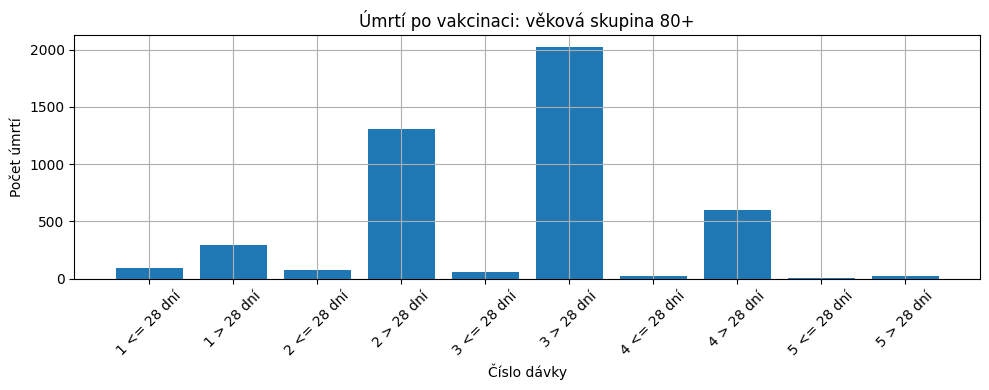

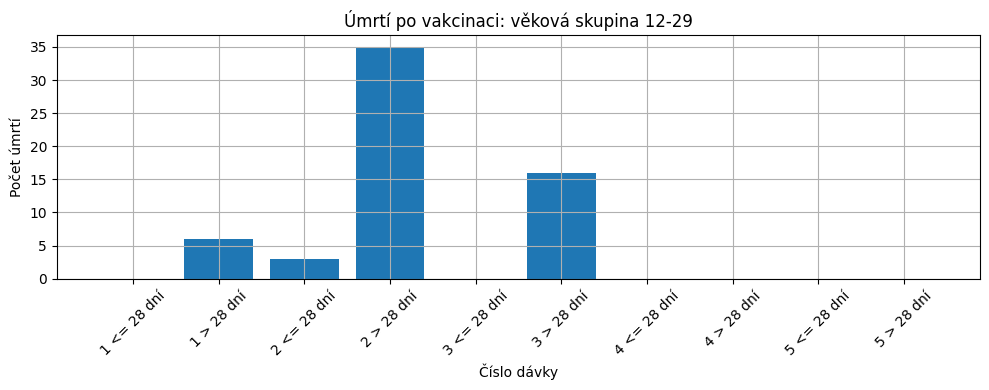

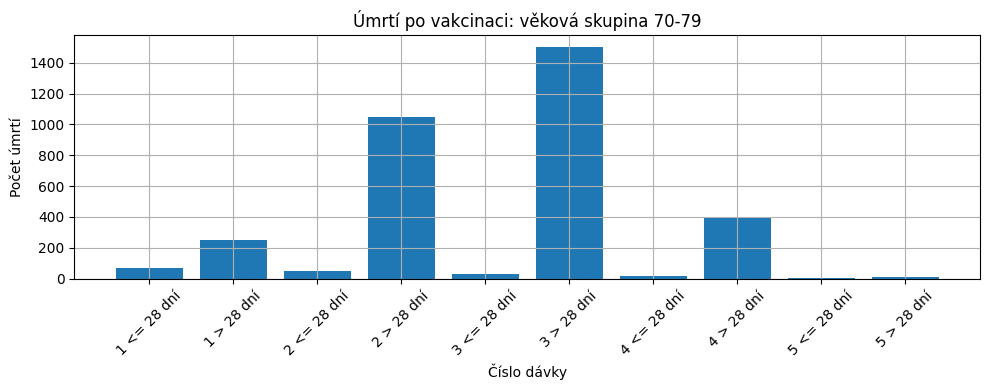

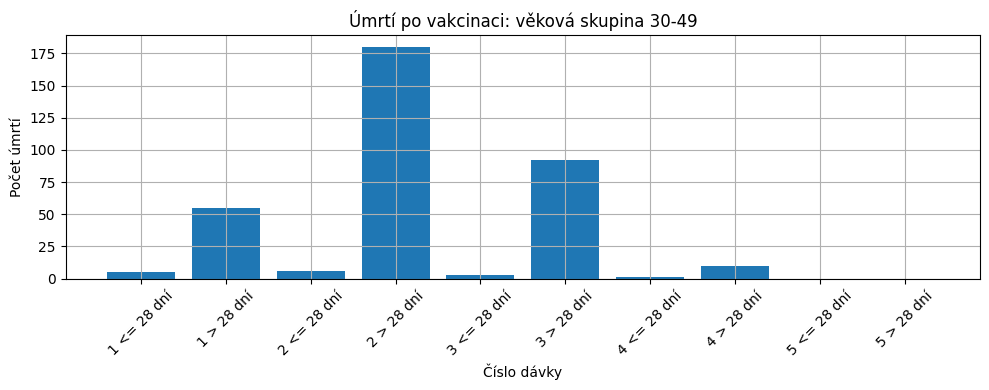

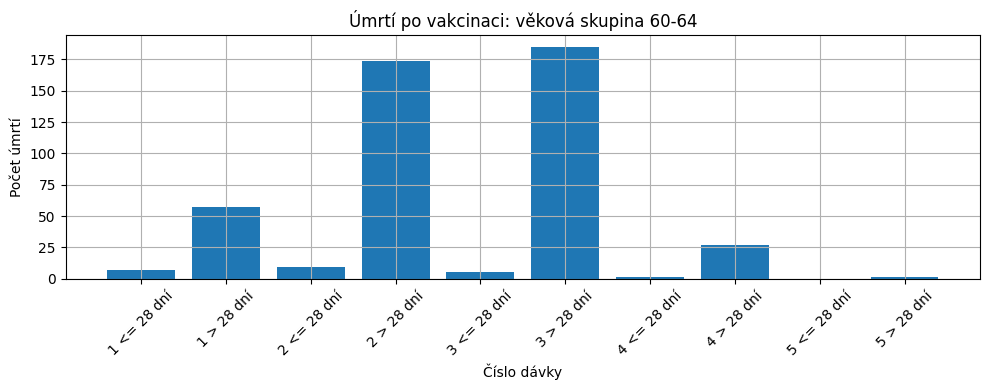

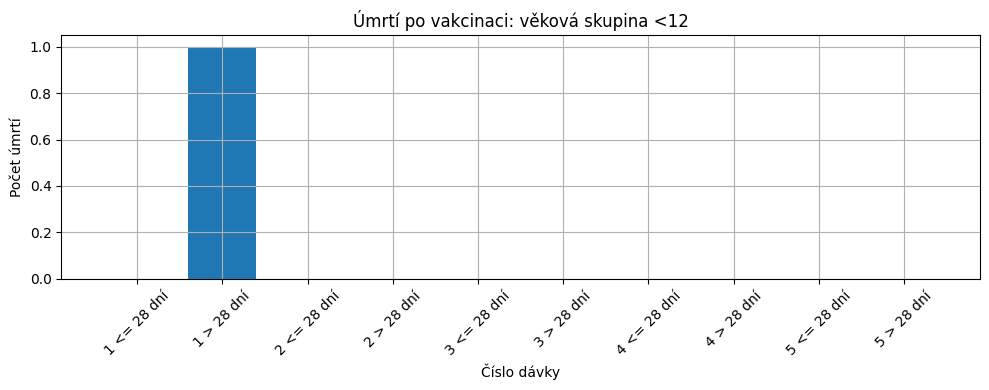

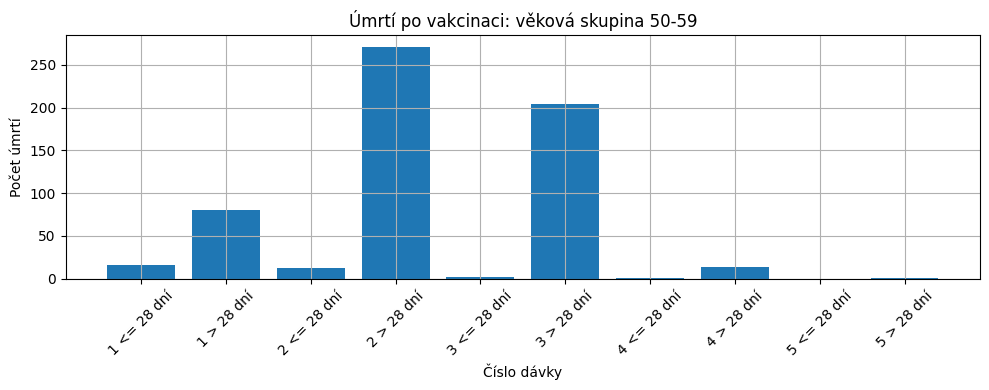

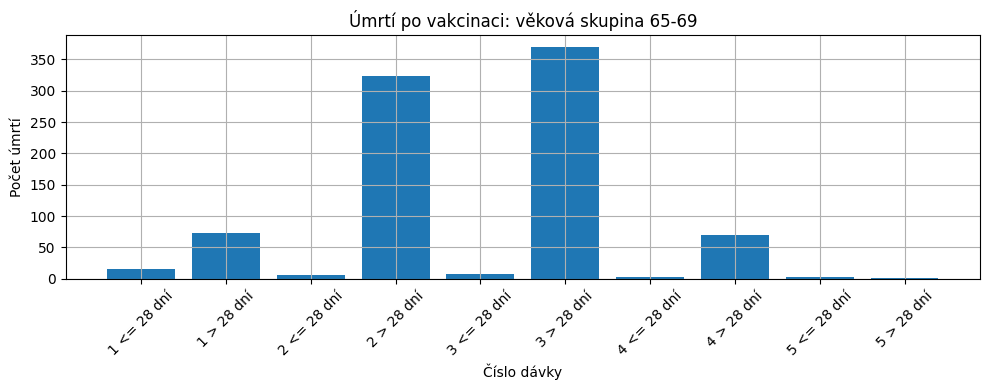

In [ ]:
for vek_kohorta in death_groups["Vekova_kohorta"].unique():
    death_groups_vek = death_groups.filter(pl.col("Vekova_kohorta") == vek_kohorta)
    bar_heights = []
    bar_labels = []
    for cislo_davky in [1, 2, 3, 4, 5]:
        death_groups_vek_cislo_davky = death_groups_vek.filter(
            pl.col("Cislo_davky") == cislo_davky
        )
        for window in ["> 28 dní", "<= 28 dní"]:
            death_groups_vek_cislo_davky_window = death_groups_vek_cislo_davky.filter(
                pl.col("vax_to_death_window") == window
            )
            bar_heights.append(death_groups_vek_cislo_davky_window["death_count"].sum())
            bar_labels.append(f"{cislo_davky} {window}")

    plt.figure(figsize=(10, 4))
    plt.bar(bar_labels, bar_heights)
    plt.title(f"Úmrtí po vakcinaci: věková skupina {vek_kohorta}")
    plt.xlabel("Číslo dávky")
    plt.ylabel("Počet úmrtí")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
ozp_death_df = ozp_df.filter(pl.col(SHARED_COLUMNS.DATUM_UMRTI).is_not_null())

print(ozp_death_df)

last_vax_and_death_delay = (
    ozp_df.filter(
        (pl.col(SHARED_COLUMNS.DATUM_UMRTI).is_not_null())
        & (pl.col(SHARED_COLUMNS.TYP_UDALOSTI) == "vakcinace")
    )
    .group_by("Id_pojistence")
    .agg(
        [
            pl.col(SHARED_COLUMNS.DATUM_UDALOSTI).max().alias("last_vax_date"),
            pl.col(SHARED_COLUMNS.DATUM_UMRTI)
            .max()
            .alias("Datum_umrti"),  # datum úmrtí by mělo být stejný v rámci ID
            pl.col(SHARED_COLUMNS.ROK_NAROZENI)
            .max()
            .alias("Rok_narozeni"),  # datum úmrtí by mělo být stejný v rámci ID
            pl.col("pocet_vakcinaci")
            .max()
            .alias("Cislo_davky"),  # volitelné – pro rozdělení podle dávky
        ]
    )
    .with_columns(
        [
            (pl.col("Datum_umrti") - pl.col("last_vax_date"))
            .dt.total_days()
            .alias("days_from_vax_to_death")
        ]
    )
    .with_columns(
        (pl.col("Datum_umrti").dt.year() - pl.col("Rok_narozeni")).alias(
            "Vek_v_dobe_umrti"
        )
    )
    .with_columns(
        pl.col("Vek_v_dobe_umrti")
        .map_elements(get_vekova_kohorta, return_dtype=pl.Utf8)
        .alias("Vekova_kohorta")
    )
    .select(
        [
            "Id_pojistence",
            "Vekova_kohorta",  # věková skupina úmrtí
            "days_from_vax_to_death",  # počet dní od poslední vakcinační doby do úmrtí
            "Cislo_davky",  # počet dávek vakcinační
        ]
    )
)

print(last_vax_and_death_delay)


death_counts = (
    last_vax_and_death_delay.group_by(
        ["Vekova_kohorta", "Cislo_davky", "days_from_vax_to_death"]
    )
    .len()
    .rename({"len": "death_count"})
    .sort(["Vekova_kohorta", "Cislo_davky", "days_from_vax_to_death"])
)

print(death_counts)

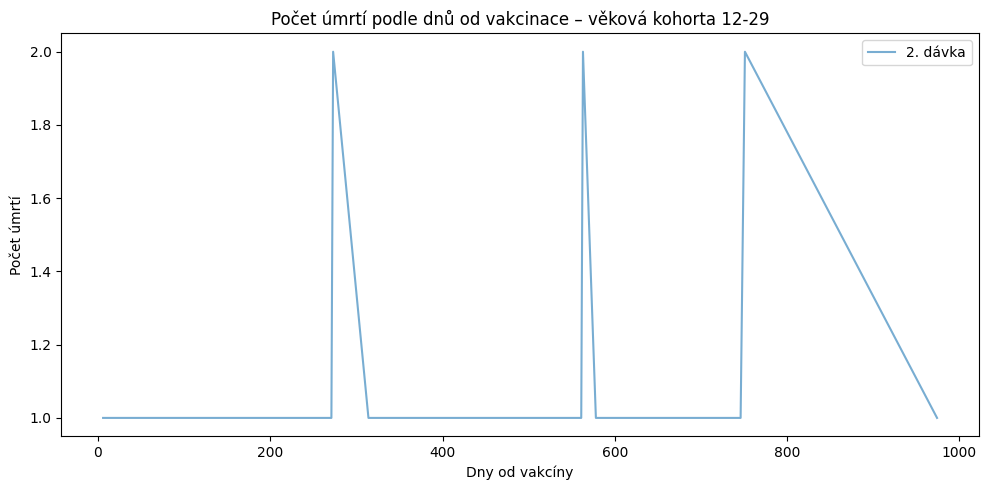

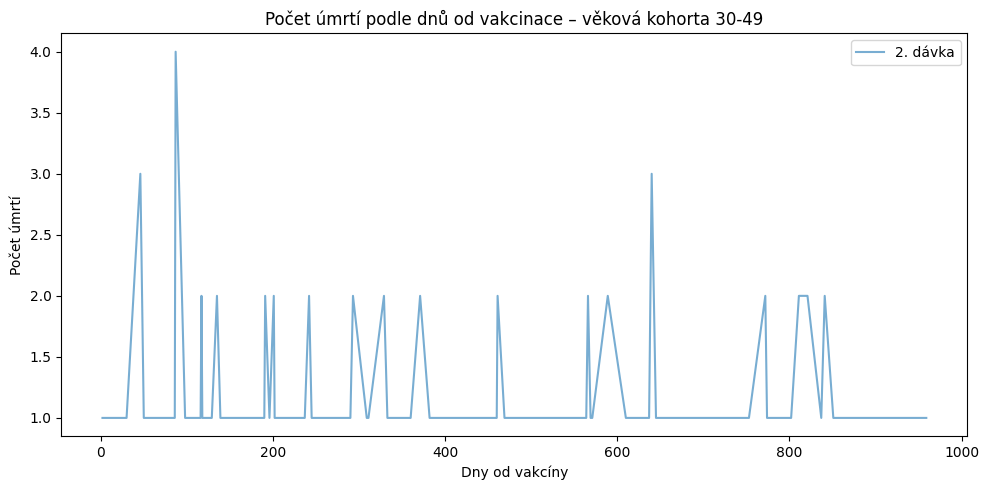

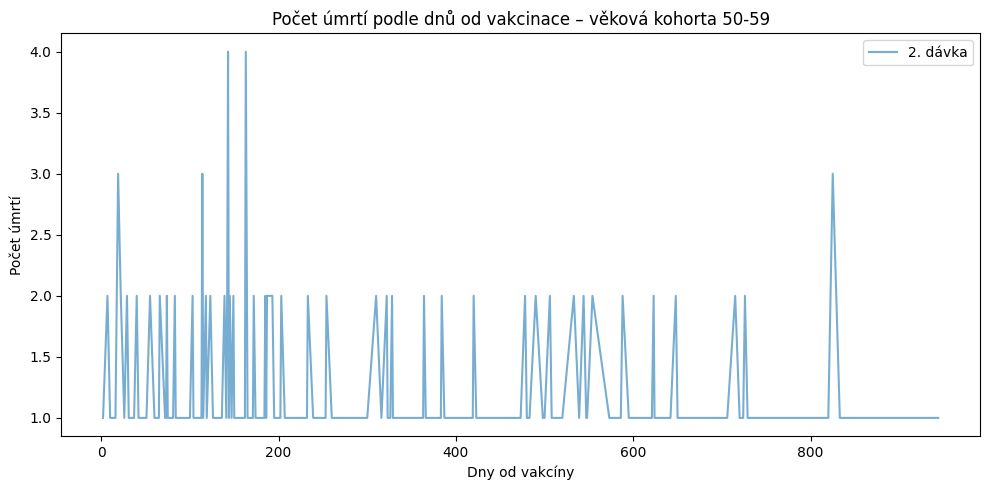

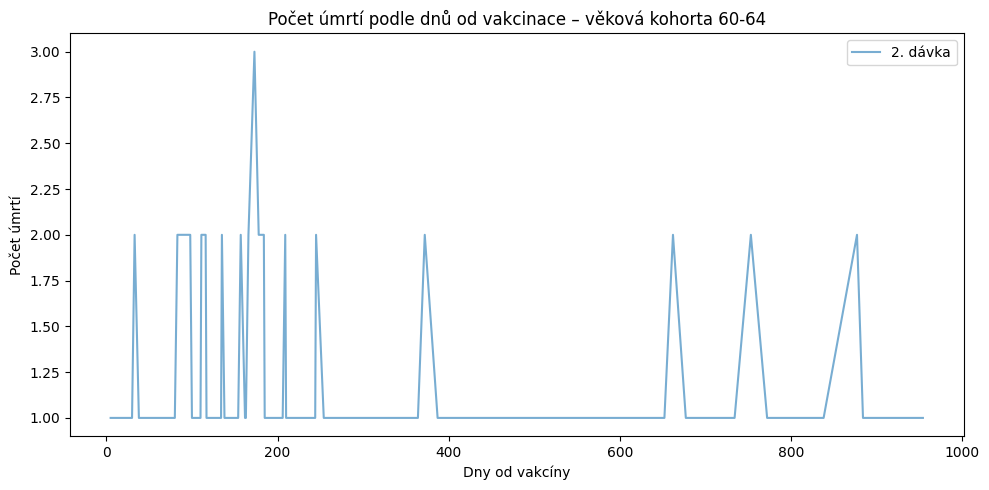

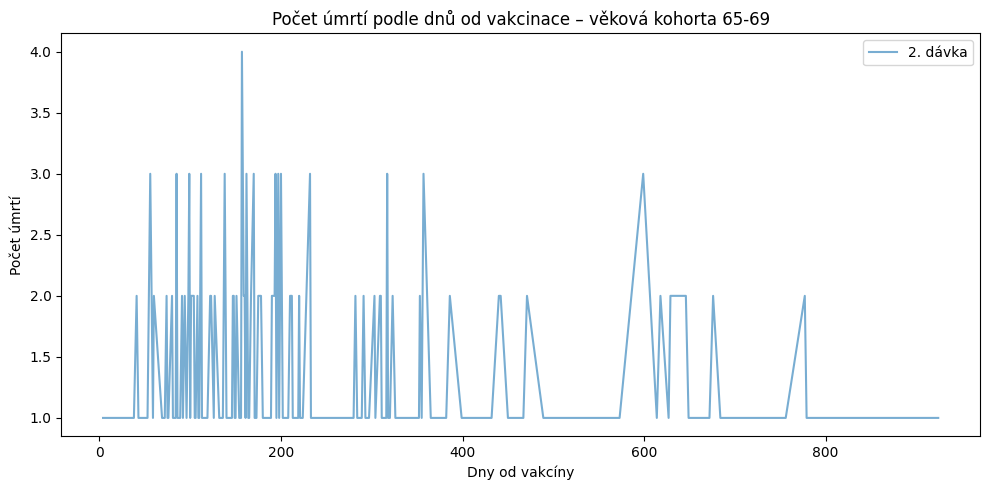

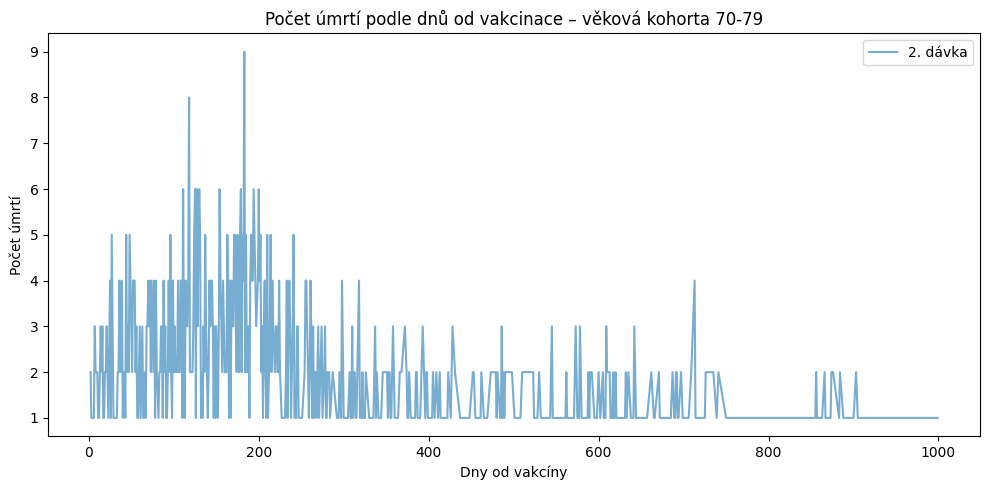

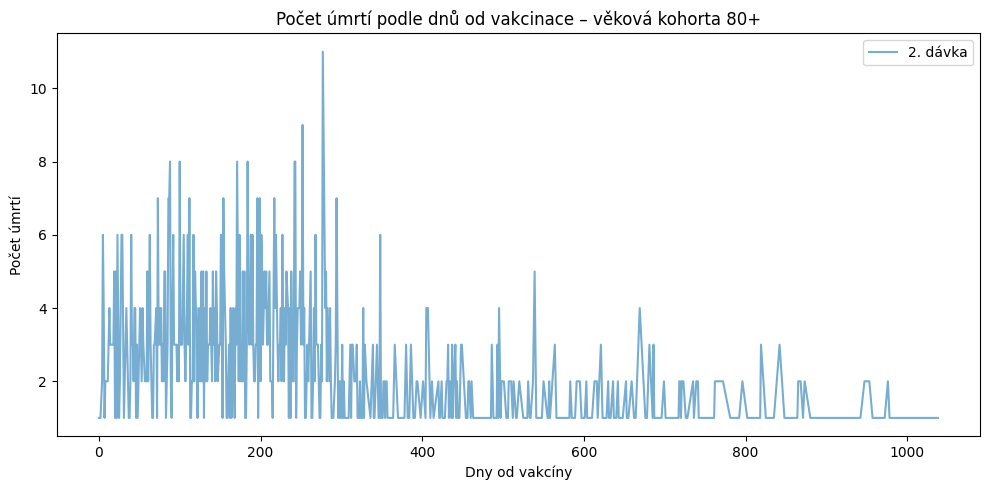

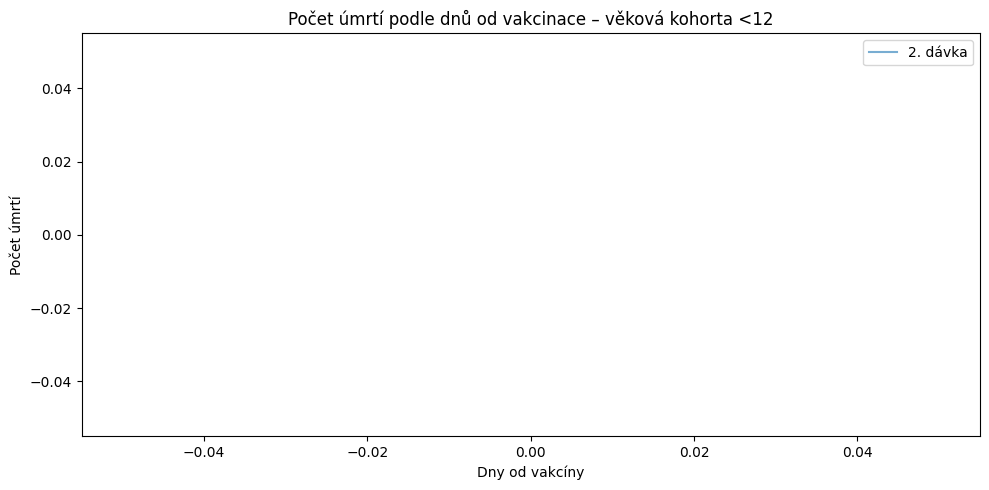

In [73]:
cohorts = death_counts.select("Vekova_kohorta").unique().to_series().to_list()
for cohort in cohorts:
    cohort_df = death_counts.filter(pl.col("Vekova_kohorta") == cohort)

    dose_counts = cohort_df.select("Cislo_davky").unique().to_series().to_list()

    plt.figure(figsize=(10, 5))

    dose = 2
    dose_df = (
        cohort_df.filter(pl.col("Cislo_davky") == dose)
        .select(["days_from_vax_to_death", "death_count"])
        .sort("days_from_vax_to_death")
    )

    data = dose_df.to_dicts()
    x = [row["days_from_vax_to_death"] for row in data]
    y = [row["death_count"] for row in data]

    # plt.plot(x, y, label=f"{dose}. dávka", alpha=0.6, marker="o", linestyle="")
    plt.plot(x, y, label=f"{dose}. dávka", alpha=0.6, linestyle="-")

    plt.title(f"Počet úmrtí podle dnů od vakcinace – věková kohorta {cohort}")
    plt.xlabel("Dny od vakcíny")
    plt.ylabel("Počet úmrtí")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()  # doporučené při batch generování grafů

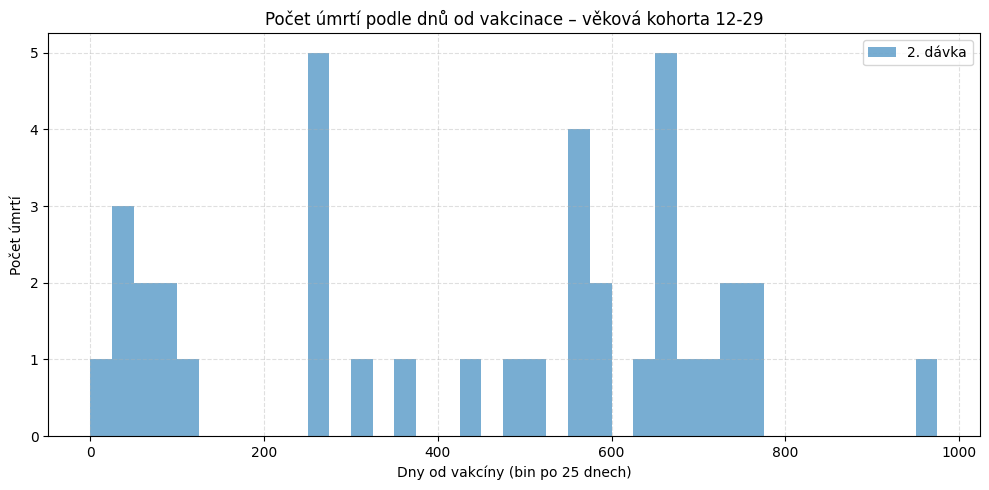

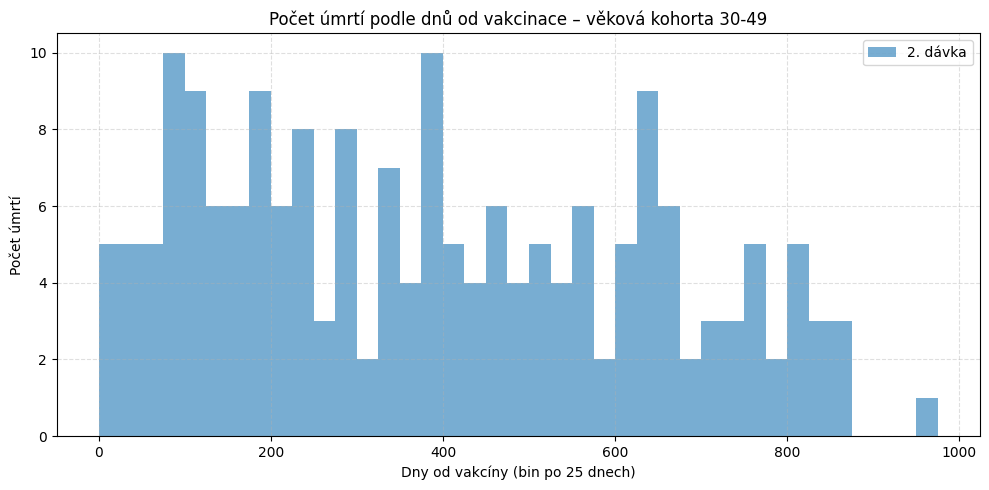

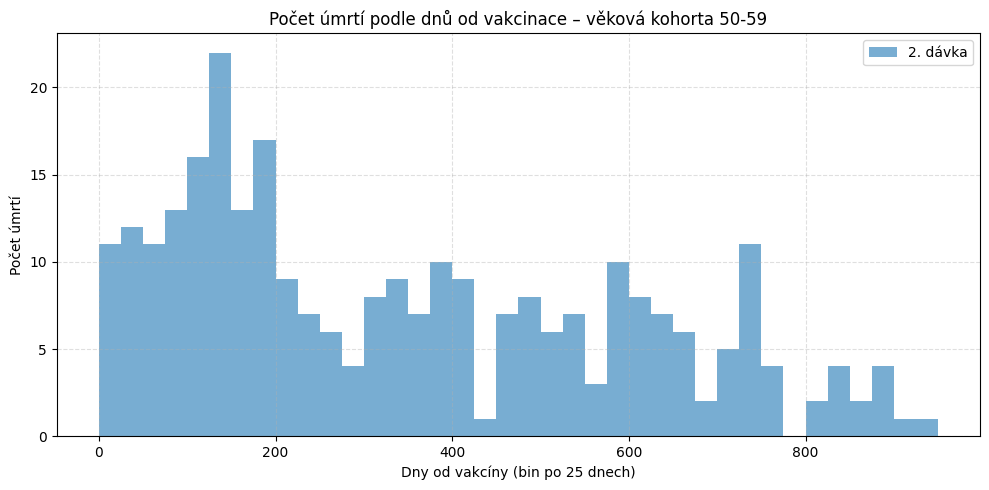

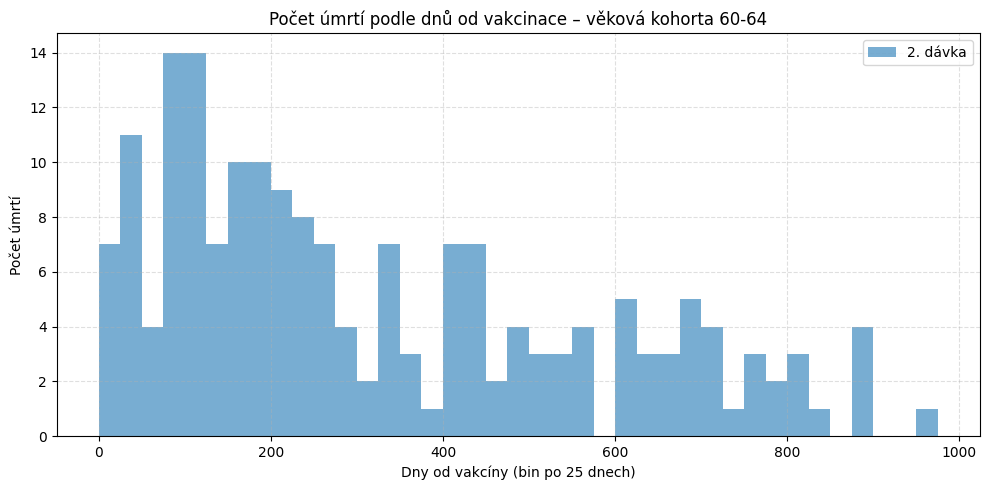

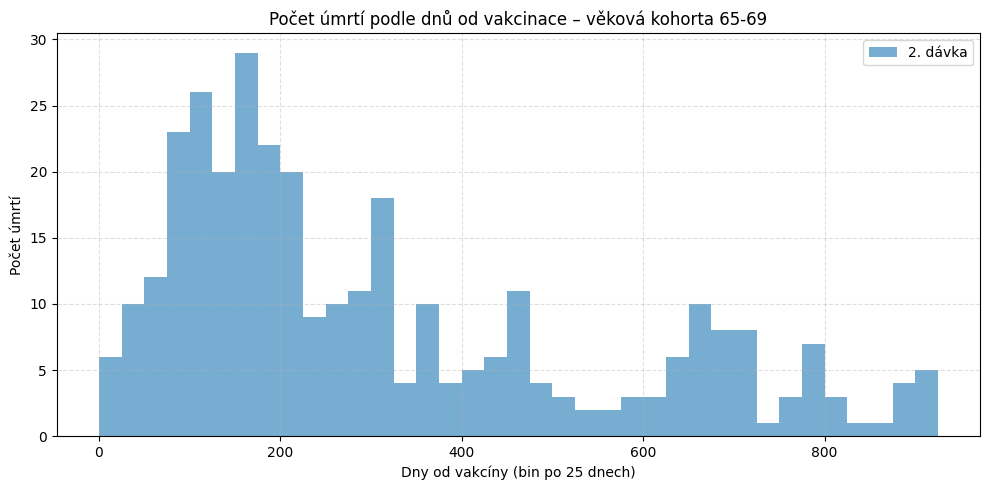

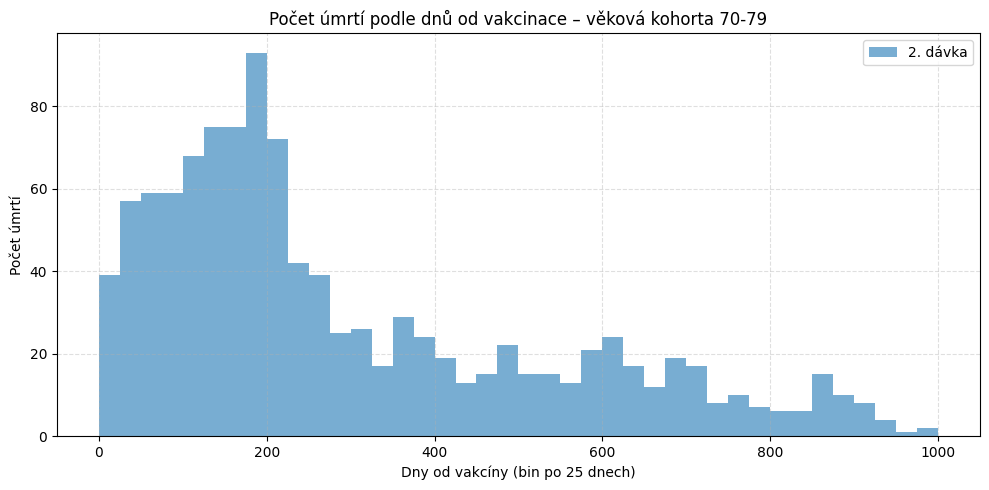

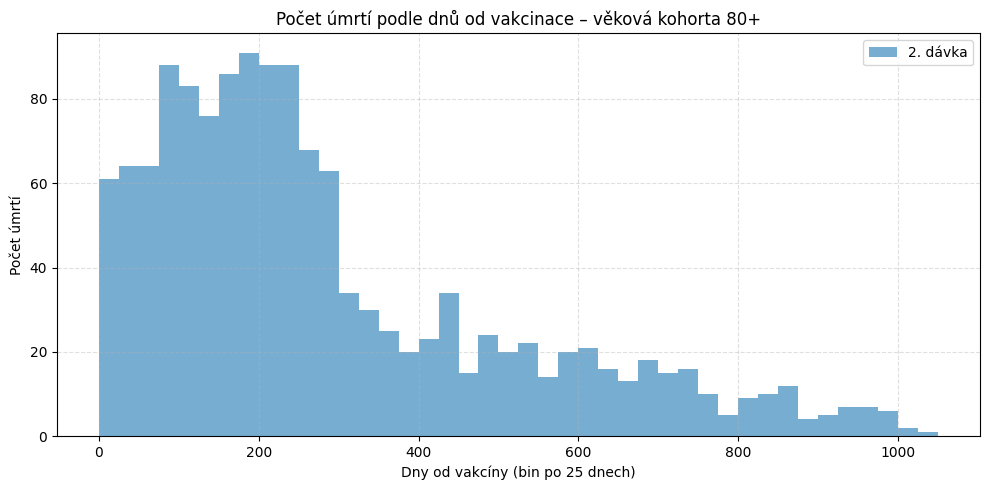

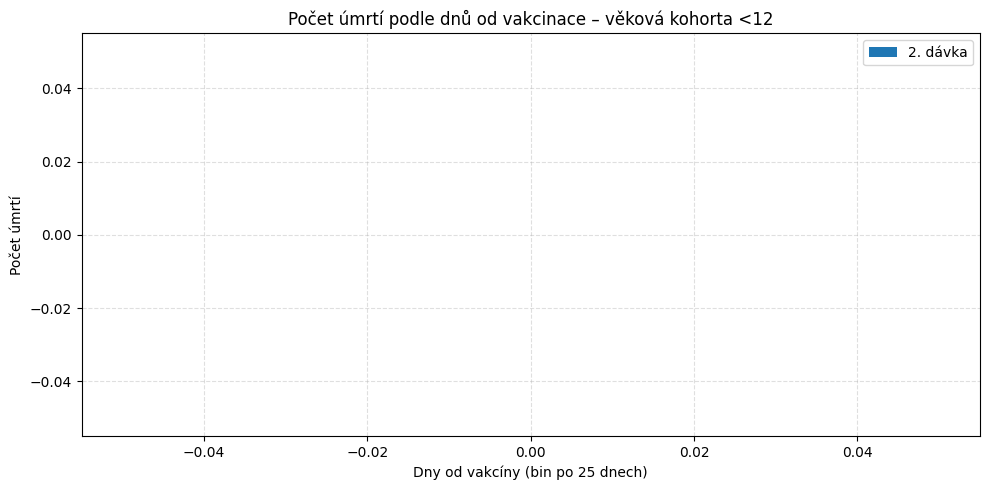

In [76]:
BIN_SIZE = 25
binned_death_counts = (
    last_vax_and_death_delay.with_columns(
        (pl.col("days_from_vax_to_death") // BIN_SIZE * BIN_SIZE).alias("days_bin")
    )
    .group_by(["Vekova_kohorta", "Cislo_davky", "days_bin"])
    .len()
    .rename({"len": "death_count"})
    .sort(["Vekova_kohorta", "Cislo_davky", "days_bin"])
)

cohorts = binned_death_counts.select("Vekova_kohorta").unique().to_series().to_list()

for cohort in cohorts:
    cohort_df = binned_death_counts.filter(pl.col("Vekova_kohorta") == cohort)

    dose_counts = cohort_df.select("Cislo_davky").unique().to_series().to_list()

    plt.figure(figsize=(10, 5))

    # for dose in sorted(dose_counts):
    dose = 2
    dose_df = (
        cohort_df.filter(pl.col("Cislo_davky") == dose)
        .select(["days_bin", "death_count"])
        .sort("days_bin")
    )

    data = dose_df.to_dicts()
    x = [row["days_bin"] for row in data]
    y = [row["death_count"] for row in data]

    plt.bar(x, y, width=BIN_SIZE, align="edge", alpha=0.6, label=f"{dose}. dávka")

    plt.title(f"Počet úmrtí podle dnů od vakcinace – věková kohorta {cohort}")
    plt.xlabel(f"Dny od vakcíny (bin po {BIN_SIZE} dnech)")
    plt.ylabel("Počet úmrtí")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()
    plt.close()